In [1]:
import numpy as np
import pandas as pd
rng = np.random.default_rng(42)

from lymph.models import Unilateral
from lymixture import LymphMixture
from lymixture.utils import binom_pmf, late_binomial, normalize

dataset = pd.read_csv('../../data/mixture_model_data_combined_complete.csv', header = [0,1,2],)
dataset_staging = dataset.copy()
dataset_staging['tumor','1','t_stage'] = dataset_staging['tumor','1','t_stage'].replace([0,1,2], 'early')
dataset_staging['tumor','1','t_stage'] = dataset_staging['tumor','1','t_stage'].replace([3,4], 'late')
dataset_staging = dataset_staging[~(dataset_staging['tumor']['1']['subsite'].str.startswith(('C00.4')))]

/tmp/ipykernel_11647/451794406.py:9: DtypeWarning: Columns (4,5,12,13,14,15,16,17,18,19,20,35,37,38,39,45,47,48,49,56,62,63,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,93,94,95,97,98,99,101,104,105,107,108,111,112,113,114,115,116,117,118,119,120,121,122,126,127,128,129,130,131,132,133,134,135,136,150,164,179,193,208,222,227,228,229,230,231,232,233,234,235,236,237,238,242,243,244,245,246,247,248,249,250,251,252,272,274,276,278,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,357,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('../../data/mixture_model_data_combined_complete.csv', header = [0,1,2],)


In [2]:
dataset_staging_main_groups = dataset_staging.copy()

# Reduce to only main subsite
# dataset_staging_main_groups.loc[:, ('tumor', '1', 'subsite')] = (
#     dataset_staging_main_groups.loc[:, ('tumor', '1', 'subsite')].str.replace(r'\..*', '', regex=True)
# )

dataset_staging_main_groups.loc[~(dataset_staging_main_groups['tumor']['1']['subsite'].str.startswith(('C32'))), ('tumor', '1', 'subsite')] = (
    dataset_staging_main_groups.loc[~(dataset_staging_main_groups['tumor']['1']['subsite'].str.startswith(('C32'))), ('tumor', '1', 'subsite')].str.replace(r'\..*', '', regex=True)
)
dataset_staging_main_groups = dataset_staging_main_groups[~(dataset_staging_main_groups['tumor']['1']['subsite'].str.startswith(('C32.3')))]
dataset_staging_main_groups = dataset_staging_main_groups[~(dataset_staging_main_groups['tumor']['1']['subsite'].str.startswith(('C32.8')))]
dataset_staging_main_groups = dataset_staging_main_groups[~(dataset_staging_main_groups['tumor']['1']['subsite'].str.startswith(('C32.9')))]


dataset_staging_main_groups['tumor']['1']['subsite'].value_counts()


subsite
C32.0    637
C09      452
C32.1    358
C12      227
C01      212
C10      169
C13      165
C02      158
C04       99
C32       97
C05       61
C06       46
C03       45
C32.2     15
Name: count, dtype: int64

In [6]:
dataset_staging_main_groups['patient']['#']['institution'].value_counts()

institution
University Medical Center Groningen    979
Centre Léon Bérard                     636
University Hospital Zurich             634
Inselspital Bern                       328
Vall d'Hebron Barcelona Hospital       164
Name: count, dtype: int64

In [8]:
graph = {
    ("tumor", "T"): ["I", "II", "III", "IV", "V"],
    ("lnl", "I"): ["II"],
    ("lnl", "II"): ["III"],
    ("lnl", "III"): ["IV"],
    ("lnl", "IV"): ["V"],
    ("lnl", "V"): [],
}

num_components = 4

mixture = LymphMixture(
    model_cls=Unilateral,
    model_kwargs={"graph_dict": graph},
    num_components=num_components,
    universal_p= False
)
# mixture.load_patient_data(
#     dataset_staging_main_groups,
#     split_by=("tumor", "1", "subsite"),
#     mapping=lambda x: x,
# )


In [9]:
mixture.load_patient_data(
    dataset_staging_main_groups,
    split_by=("tumor", "1", "subsite"),
    mapping=lambda x: x,
)

In [10]:
mixture.patient_data

index                              patient                            \
                                              #                             
                                    institution     sex age diagnose_date   
0      979           University Hospital Zurich    male  59    2017-08-30   
1     1105           University Hospital Zurich    male  51    2017-02-13   
2     1106           University Hospital Zurich    male  65    2014-02-03   
3     1135           University Hospital Zurich    male  56    2014-04-21   
4     1136           University Hospital Zurich    male  35    2014-05-08   
...    ...                                  ...     ...  ..           ...   
2736   587  University Medical Center Groningen    male  83    2014-05-16   
2737   588  University Medical Center Groningen  female  67    2019-09-11   
2738   589  University Medical Center Groningen  female  81    2021-10-11   
2739   881  University Medical Center Groningen    male  71    2019-10-10   
2740  1510           University Hospital Zurich  female  53    2021-10-29   

                                                                         ...  \
                                                                         ...   
     alcohol_abuse nicotine_abuse pack_years hpv_status neck_dissection  ...   
0             True           True        NaN       True           False  ...   
1             True           True        NaN       True           False  ...   
2             True           True        NaN       True           False  ...   
3             True           True        NaN       True           False  ...   
4             True           True        NaN       True           False  ...   
...            ...            ...        ...        ...             ...  ...   
2736          True           True        NaN        NaN           False  ...   
2737         False           True       20.0        NaN           False  ...   
2738         False          False        NaN        NaN           False  ...   
2739          True           True      114.0        NaN           False  ...   
2740         False          False        NaN        NaN           False  ...   

     _model                                                               
        pCT                      total_dissected                       #  
         II    III     IV      V               I  II III  IV   V t_stage  
0      True  False  False  False             NaN NaN NaN NaN NaN    late  
1      True   True  False  False             NaN NaN NaN NaN NaN    late  
2      True  False  False  False             NaN NaN NaN NaN NaN    late  
3      True   True  False  False             NaN NaN NaN NaN NaN    late  
4      True   True  False  False             NaN NaN NaN NaN NaN   early  
...     ...    ...    ...    ...             ...  ..  ..  ..  ..     ...  
2736    NaN    NaN    NaN    NaN             NaN NaN NaN NaN NaN   early  
2737    NaN    NaN    NaN    NaN             NaN NaN NaN NaN NaN    late  
2738    NaN    NaN    NaN    NaN             NaN NaN NaN NaN NaN   early  
2739    NaN    NaN    NaN    NaN             NaN NaN NaN NaN NaN    late  
2740  False  False  False  False             NaN NaN NaN NaN NaN    late  

[2741 rows x 492 columns]

In [11]:
mixture.set_distribution("early", binom_pmf(np.arange(11), 10, 0.3))
mixture.set_distribution("late", late_binomial)
mixture.set_modality("diagnostic_consensus", 1., 1.)

In [12]:
mixture.subgroups.keys()

dict_keys(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C09', 'C10', 'C12', 'C13', 'C32', 'C32.0', 'C32.1', 'C32.2'])

Initialize random model parameters and latent variables/responsibilities.

In [13]:
from lymixture.em import expectation, maximization

params = {k: rng.uniform() for k in mixture.get_params()}

mixture.set_params(**params)
mixture.normalize_mixture_coefs()
git = normalize(rng.uniform(size=mixture.get_resps().shape).T, axis=0).T

In [14]:
def to_numpy(params: dict[str, float]) -> np.ndarray:
    return np.array([p for p in params.values()])

In [15]:
mixture.get_mixture_coefs()

,C01,C02,C03,C04,C05,C06,C09,C10,C12,C13,C32,C32.0,C32.1,C32.2
0,0.206668,0.663046,0.439528,0.442438,0.226472,0.106990,0.310218,0.032708,0.369575,0.324880,0.366700,0.179323,0.517906,0.402260
1,0.261712,0.135556,0.088690,0.255809,0.115893,0.315366,0.244529,0.426769,0.312700,0.160658,0.402579,0.407057,0.206735,0.129862
2,0.077917,0.081940,0.456278,0.253331,0.288692,0.360181,0.355042,0.283724,0.249711,0.156329,0.014907,0.220896,0.114490,0.184000
3,0.453703,0.119459,0.015504,0.048423,0.368942,0.217464,0.090211,0.256799,0.068014,0.358134,0.215814,0.192724,0.160869,0.283878


Iterate the computation of the expectation value of the latent variables (E-step) and the maximization of the (complete) data log-likelihood w.r.t. the model parameters (M-step).

In [16]:
def check_convergence(params_history, likelihood_history, steps_back_list):
    current_params = params_history[-1]
    current_likelihood = likelihood_history[-1]
    for steps_back in steps_back_list:
        previous_params = params_history[-steps_back - 1]
        if np.allclose(to_numpy(current_params), to_numpy(previous_params)):
            print('stopped due to parameter similarity')
            return True  # Return True if any of the steps is close
        elif (np.isclose(current_likelihood, likelihood_history[-steps_back - 1],rtol = 0, atol = 0.01)) and np.all(current_likelihood >= np.array(likelihood_history)):
            print('stopped due to likelihood similarity')
            return True
    return False

In [17]:
is_converged = False
count = 0
params_history = []
likelihood_history = []
params_history.append(params.copy())
likelihood_history.append(mixture.likelihood(use_complete=False))
# Number of steps to look back for convergence
look_back_steps = 3

while not is_converged:
    print(count)
    print(likelihood_history[-1])
    old_params = params
    latent = expectation(mixture, params)
    params = maximization(mixture, latent)
    
    # Append current params and likelihood to history
    params_history.append(params.copy())
    likelihood_history.append(mixture.likelihood(use_complete=False))
    
    # Check if converged
    if count >= 3:  # Ensure enough history is available
        is_converged = check_convergence(params_history, likelihood_history,list(range(1,look_back_steps+1)))
    count += 1

0
-14390.360757522834
1
-5038.422047118569
2
-4985.357336308992
3
-4934.831544949298
4
-4860.253743865224
5
-4755.130859725455
6
-4642.783980802398
7
-4549.883348969487
8
-4492.033798195309
9
-4462.869288927679
10
-4446.7447014945865
11
-4437.125796741788
12
-4430.693764048284
13
-4426.264380781065
14
-4422.970502250027
15
-4420.64884449013
16
-4418.674532794446
17
-4416.881695291146
18
-4415.21536268387
19
-4413.610893654233
20
-4412.04523721907
21
-4410.501306302138
22
-4408.93060865013
23
-4407.328891745394
24
-4405.649149575276
25
-4403.863926371632
26
-4401.950487916788
27
-4399.881295440464
28
-4397.612878151973
29
-4395.2447596028105
30
-4392.836578150418
31
-4390.33716141654
32
-4387.883792947807
33
-4385.477405145549
34
-4383.16372461386
35
-4380.8272244792315
36
-4378.48907288874
37
-4376.074288389305
38
-4373.5693973437665
39
-4371.021193352111
40
-4368.463970232086
41
-4365.938811537249
42
-4363.507547052523
43
-4361.196926522956
44
-4359.025472206735
45
-4357.0112457905825

In [18]:
likelihood_history

[-14390.360757522834,
 -5038.422047118569,
 -4985.357336308992,
 -4934.831544949298,
 -4860.253743865224,
 -4755.130859725455,
 -4642.783980802398,
 -4549.883348969487,
 -4492.033798195309,
 -4462.869288927679,
 -4446.7447014945865,
 -4437.125796741788,
 -4430.693764048284,
 -4426.264380781065,
 -4422.970502250027,
 -4420.64884449013,
 -4418.674532794446,
 -4416.881695291146,
 -4415.21536268387,
 -4413.610893654233,
 -4412.04523721907,
 -4410.501306302138,
 -4408.93060865013,
 -4407.328891745394,
 -4405.649149575276,
 -4403.863926371632,
 -4401.950487916788,
 -4399.881295440464,
 -4397.612878151973,
 -4395.2447596028105,
 -4392.836578150418,
 -4390.33716141654,
 -4387.883792947807,
 -4385.477405145549,
 -4383.16372461386,
 -4380.8272244792315,
 -4378.48907288874,
 -4376.074288389305,
 -4373.5693973437665,
 -4371.021193352111,
 -4368.463970232086,
 -4365.938811537249,
 -4363.507547052523,
 -4361.196926522956,
 -4359.025472206735,
 -4357.0112457905825,
 -4355.144667779305,
 -4353.4107142

In [19]:
import json

# Saving the list of dictionaries to a file
with open('params_history_4_comp_split_t_stage_add_larynx_split.json', 'w') as f:
    json.dump(params_history, f, indent=4)

# # Loading the list of dictionaries from the file
# with open('params_history_4_comp_split_t_stage_add_larynx_split.json', 'r') as f:
#     params_history_loaded = json.load(f)

In [22]:
a = np.array(likelihood_history)
np.savetxt('likelihoods_4_comp_split_t_stage_add_larynx_split.txt', a, fmt='%.6f')
# b = np.loadtxt('likelihoods_4_comp_split_t_stage_add_larynx.txt', dtype=float)
# b


In [16]:
likelihood_history = b

In [17]:
params_history = params_history_loaded

In [23]:
differences = []
for i in range(len(params_history)-1):
    differences.append(np.abs(np.array(list(params_history[i].values())) - np.array(list(params_history[i+1].values()))).sum())
differences

[29.05901985876218,
 1.883075735193357,
 1.6421647202529837,
 1.8435013009152024,
 2.2021643694358826,
 2.360469407612756,
 2.2707761676120097,
 1.7710416684847914,
 1.0229468263010468,
 0.822389961381139,
 0.7362734473127545,
 0.6548143600124553,
 0.49962278004775224,
 0.44315414769748873,
 0.36842087556394476,
 0.32569271831758134,
 0.2854067952882559,
 0.25650308506007274,
 0.235838000636682,
 0.21636906204988626,
 0.22469962245010128,
 0.23617348183747217,
 0.2526482853701919,
 0.27097518740731735,
 0.29582143127266863,
 0.3290719895351212,
 0.3713845215686662,
 0.4465575619455304,
 0.5018951829556776,
 0.3092555467491321,
 0.2964251393633448,
 0.2993654373037704,
 0.2846530321800223,
 0.2772552481487758,
 0.268807663452188,
 0.2625540159480012,
 0.2543406483805227,
 0.2474624767043599,
 0.24383251231600647,
 0.23883741244412715,
 0.2346599654561879,
 0.23126673064321102,
 0.22725367103258115,
 0.22416915894791978,
 0.21978915223844933,
 0.21532025024716964,
 0.21064412045983572,
 

Text(0.5, 1.0, 'Convergence of EM algorithm 4 comp 4 locs')

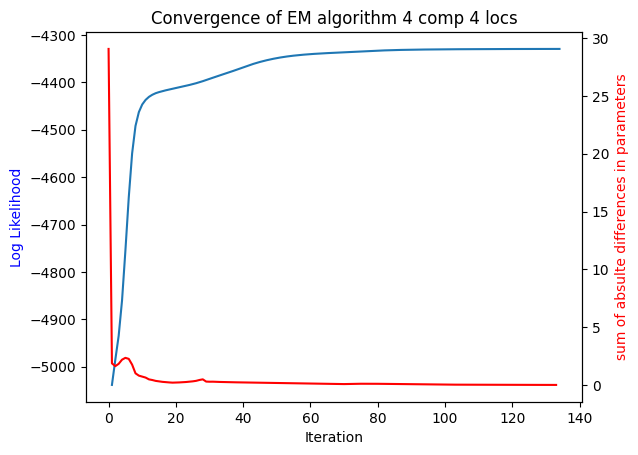

In [24]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.plot(np.array(range(len(likelihood_history[1:])))+1,likelihood_history[1:])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Log Likelihood', color='blue')
ax2 = ax1.twinx()
ax2.plot(differences, color='red')  
ax2.set_ylabel('sum of absulte differences in parameters', color='red')
ax1.set_title('Convergence of EM algorithm 4 comp 4 locs')

In [25]:
params = params_history[np.argmax(likelihood_history)]
mixture.set_params(**params)
mixture.normalize_mixture_coefs()
latent = normalize(rng.uniform(size=mixture.get_resps().shape).T, axis=0).T

In [26]:
mixture.likelihood(use_complete=False)

-4329.56664291639

In [27]:
mixture._mixture_coefs

,C01,C02,C03,C04,C05,C06,C09,C10,C12,C13,C32,C32.0,C32.1,C32.2
0,0.094386,0.112324,1.946236e-76,0.066406,0.015668,2.246571e-14,0.094143,0.250723,9.445071e-01,8.532620e-01,5.205442e-01,1.370467e-02,4.738318e-01,1.724861e-03
1,0.000035,0.200639,7.321306e-02,0.101981,0.073327,2.262760e-01,0.085065,0.183658,5.330863e-02,1.357791e-01,4.789462e-01,9.862953e-01,4.318185e-01,9.982751e-01
2,0.893029,0.244125,6.032035e-46,0.057313,0.414490,2.991686e-09,0.795707,0.505443,2.184252e-03,1.095891e-02,5.095900e-04,1.847474e-15,9.434972e-02,6.612989e-19
3,0.012551,0.442912,9.267869e-01,0.774300,0.496515,7.737240e-01,0.025086,0.060176,2.815268e-11,7.888705e-16,6.306150e-28,2.199756e-15,2.417170e-09,2.993748e-19


In [28]:
mixture.get_params()

{'0_TtoI_spread': 0.011482685876430018,
 '0_TtoII_spread': 0.2946411955894784,
 '0_TtoIII_spread': 0.2052386680574092,
 '0_TtoIV_spread': 0.05120828383950691,
 '0_TtoV_spread': 0.03326323775841986,
 '0_ItoII_spread': 6.610696135189607e-05,
 '0_IItoIII_spread': 0.027163240566653604,
 '0_IIItoIV_spread': 0.044151409590785555,
 '0_IVtoV_spread': 0.06150722061189472,
 '0_late_p': 0.3906635834748328,
 '0_C01_coef': 0.094385610944458,
 '0_C02_coef': 0.11232419794487583,
 '0_C03_coef': 1.9462363636925658e-76,
 '0_C04_coef': 0.06640603217637356,
 '0_C05_coef': 0.015668238998295628,
 '0_C06_coef': 2.2465710899252062e-14,
 '0_C09_coef': 0.09414297105163875,
 '0_C10_coef': 0.25072327185911053,
 '0_C12_coef': 0.9445071154745129,
 '0_C13_coef': 0.8532619618409961,
 '0_C32_coef': 0.5205442261934288,
 '0_C32.0_coef': 0.013704669911945834,
 '0_C32.1_coef': 0.47383182433544024,
 '0_C32.2_coef': 0.0017248610028145243,
 '1_TtoI_spread': 0.00020640360553998615,
 '1_TtoII_spread': 0.013732320655600497,
 '1

In [29]:
subgroup = 'C32'
t_stage = 'late'
desired_lnl = 'II'
lnls = np.array(['I','II','III','IV','V'])
involvement = {'I': None, 'II': None, 'III': None, 'IV': None, 'V': None}



subgroup_combinations_short = pd.DataFrame(mixture.subgroups[subgroup].patient_data['_model']['diagnostic_consensus'].loc[mixture.subgroups[subgroup].patient_data['_model']['#']['t_stage'] == t_stage].value_counts()/((mixture.subgroups[subgroup].patient_data['_model']['#']['t_stage'] == t_stage) & (np.all(mixture.subgroups[subgroup].patient_data['_model']['diagnostic_consensus'].notna(),axis = 1))).sum().sum())
# Convert the Series to DataFrame
df = subgroup_combinations_short.reset_index()
df.columns = ['I', 'II', 'III', 'IV', 'V', 'prevalence']

# Convert boolean columns to tuples
df['predicted'] = df[['I', 'II', 'III', 'IV', 'V']].apply(lambda row: tuple(int(x) for x in row), axis=1)

# Drop the original boolean columns
df = df.drop(columns=['I', 'II', 'III', 'IV', 'V'])

import itertools

# Define the number of features (length of the combination list)
num_features = 5  # Update based on your data length

# Generate all possible combinations of binary values (0 or 1)
combinations = list(itertools.product([0, 1], repeat=num_features))

# Create a DataFrame with all combinations and default probability of 0
subgroup_combinations = pd.DataFrame(combinations, columns=[f'Feature_{i+1}' for i in range(num_features)])
subgroup_combinations['predicted'] = subgroup_combinations.apply(lambda row: tuple(row), axis=1)
subgroup_combinations.drop(columns=[f'Feature_{i+1}' for i in range(num_features)], inplace=True)
# Merge with the existing probabilities
subgroup_combinations = pd.merge(subgroup_combinations, df, on='predicted', how='left').fillna(0)
subgroup_combinations.drop(columns=['predicted'], inplace=True)

mixture.state_dist(subgroup=subgroup)
df = pd.DataFrame(np.array([mixture.state_dist(subgroup=subgroup,t_stage=t_stage)]), columns = [str(col) for col in mixture.components[0].graph.state_list])
df = df.T
df.columns = ['predicted']
subgroup_combinations['index'] = df.index
subgroup_combinations.set_index('index', inplace=True)
df_final = pd.concat([subgroup_combinations, df],axis = 1)
df_final['difference'] = df_final['predicted'] - df_final['prevalence']

lnl_index = np.where(lnls == desired_lnl)[0][0]
indices = []
for i, state in enumerate(mixture.components[0].graph.state_list):
    if state[lnl_index] == 1:
        indices.append(i)
print(desired_lnl, subgroup_combinations.iloc[indices].sum()*100,)
involvement[desired_lnl] = True
print('predicted involvement of', desired_lnl, mixture.risk(subgroup=subgroup, t_stage=t_stage, involvement=involvement)*100)

(df_final*100)

II prevalence    30.508475
dtype: float64
predicted involvement of II 42.96105247001465


,prevalence,predicted,difference
[0 0 0 0 0],49.152542,45.819444,-3.333098
[0 0 0 0 1],3.389831,0.584428,-2.805403
[0 0 0 1 0],0.000000,1.086805,1.086805
[0 0 0 1 1],0.000000,0.162896,0.162896
[0 0 1 0 0],15.254237,6.387893,-8.866345
[0 0 1 0 1],1.694915,0.604441,-1.090474
[0 0 1 1 0],0.000000,1.449080,1.449080
[0 0 1 1 1],0.000000,0.318519,0.318519
[0 1 0 0 0],11.864407,12.752890,0.888483
[0 1 0 0 1],10.169492,1.262049,-8.907442


## Load/Save Data

In [30]:
import pickle 
from lymixture.em import expectation, maximization

with open('params_I_to_V_ipsi_4_comp_split_t_stages_add_larynx_split.pkl', 'wb') as f:
    pickle.dump(params, f)
        
# with open('params_I_to_V_ipsi_4_comp_split_t_stages_add_larynx.pkl', 'rb') as f:
#     loaded_dict = pickle.load(f)
# params = loaded_dict
# mixture.set_params(**loaded_dict)
# mixture.normalize_mixture_coefs()
# mixture.set_resps(expectation(mixture, loaded_dict))
# mixture.likelihood(use_complete= False)

In [31]:
mixture.likelihood(use_complete= True)


-5428.863872437391

In [32]:
mixture.get_mixture_coefs()

,C01,C02,C03,C04,C05,C06,C09,C10,C12,C13,C32,C32.0,C32.1,C32.2
0,0.094386,0.112324,1.946236e-76,0.066406,0.015668,2.246571e-14,0.094143,0.250723,9.445071e-01,8.532620e-01,5.205442e-01,1.370467e-02,4.738318e-01,1.724861e-03
1,0.000035,0.200639,7.321306e-02,0.101981,0.073327,2.262760e-01,0.085065,0.183658,5.330863e-02,1.357791e-01,4.789462e-01,9.862953e-01,4.318185e-01,9.982751e-01
2,0.893029,0.244125,6.032035e-46,0.057313,0.414490,2.991686e-09,0.795707,0.505443,2.184252e-03,1.095891e-02,5.095900e-04,1.847474e-15,9.434972e-02,6.612989e-19
3,0.012551,0.442912,9.267869e-01,0.774300,0.496515,7.737240e-01,0.025086,0.060176,2.815268e-11,7.888705e-16,6.306150e-28,2.199756e-15,2.417170e-09,2.993748e-19


## Mixture evaluation

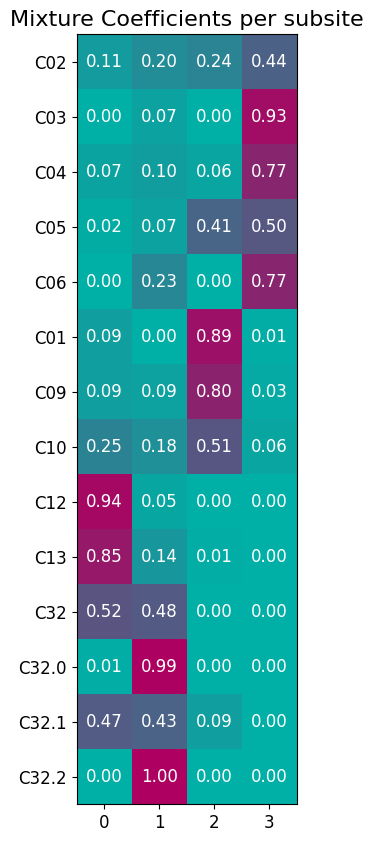

In [33]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap

# USZ colors
usz_blue = '#005ea8'
usz_green = '#00afa5'
usz_red = '#ae0060'
usz_orange = '#f17900'
usz_gray = '#c5d5db'

# colormaps
white_to_blue  = LinearSegmentedColormap.from_list("white_to_blue", 
                                                   ["#ffffff", usz_blue], 
                                                   N=256)
white_to_green = LinearSegmentedColormap.from_list("white_to_green", 
                                                   ["#ffffff", usz_green], 
                                                   N=256)
green_to_red   = LinearSegmentedColormap.from_list("green_to_red", 
                                                   [usz_green, usz_red], 
                                                   N=256)

h = usz_gray.lstrip('#')
gray_rgba = tuple(int(h[i:i+2], 16) / 255. for i in (0, 2, 4)) + (1.0,)
tmp = LinearSegmentedColormap.from_list("tmp", [usz_green, usz_red], N=128)

matrix = mixture.get_mixture_coefs()[['C02', 'C03', 'C04', 'C05', 'C06', 'C01', 'C09', 'C10', 'C12', 'C13','C32', 'C32.0', 'C32.1', 'C32.2']]

# Transpose the matrix to rotate by 90°
matrix_rotated = matrix.T

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 10))

# Display the rotated matrix using imshow
cax = ax.imshow(matrix_rotated.values, cmap=tmp, origin='upper')

# Loop over the data and create text annotations
for i in range(matrix_rotated.shape[0]):  # Rows (previously columns)
    for j in range(matrix_rotated.shape[1]):  # Columns (previously rows)
        value = matrix_rotated.iloc[i, j]
        ax.text(j, i, f"{value:.2f}", ha="center", va="center", 
                color="white", fontsize=12)


# Optional: Set axis labels and title
ax.set_xticks(range(matrix_rotated.shape[1]))
ax.set_xticklabels(matrix.index, fontsize = 12)  # Original row labels
ax.set_yticks(range(matrix_rotated.shape[0]))
ax.set_yticklabels(matrix.columns, fontsize = 12)  # Original column labels
ax.set_title("Mixture Coefficients per subsite", fontsize = 16)
plt.show()


In [34]:
params

{'0_TtoI_spread': 0.011482685876430018,
 '0_TtoII_spread': 0.2946411955894784,
 '0_TtoIII_spread': 0.2052386680574092,
 '0_TtoIV_spread': 0.05120828383950691,
 '0_TtoV_spread': 0.03326323775841986,
 '0_ItoII_spread': 6.610696135189607e-05,
 '0_IItoIII_spread': 0.027163240566653604,
 '0_IIItoIV_spread': 0.044151409590785555,
 '0_IVtoV_spread': 0.06150722061189472,
 '0_late_p': 0.3906635834748328,
 '0_C01_coef': 0.094385610944458,
 '0_C02_coef': 0.11232419794487583,
 '0_C03_coef': 1.9462363636925658e-76,
 '0_C04_coef': 0.06640603217637356,
 '0_C05_coef': 0.015668238998295628,
 '0_C06_coef': 2.2465710899252062e-14,
 '0_C09_coef': 0.09414297105163875,
 '0_C10_coef': 0.25072327185911053,
 '0_C12_coef': 0.9445071154745129,
 '0_C13_coef': 0.8532619618409961,
 '0_C32_coef': 0.5205442261934288,
 '0_C32.0_coef': 0.013704669911945834,
 '0_C32.1_coef': 0.47383182433544024,
 '0_C32.2_coef': 0.0017248610028145243,
 '1_TtoI_spread': 0.00020640360553998615,
 '1_TtoII_spread': 0.013732320655600497,
 '1

## 3d Simplex plot

In [35]:
import math
def p_to_xyz(p):
    #Project 4D representation down to 3D representation
    s3 = 1/math.sqrt(3.0)
    s6 = 1/math.sqrt(6.0)
    x =  -1*p[0] +  1*p[1] +    0*p[2] +    0*p[3]
    y = -s3*p[0] - s3*p[1] + 2*s3*p[2] +    0*p[3]
    z = -s3*p[0] - s3*p[1] -   s3*p[2] + 3*s6*p[3]
    return x, y, z

def add_perpendicular_crosses_3d(ax, x1, y1, z1, x2, y2, z2, tick_length=0.03):
    num_ticks = 6  # Number of ticks
    for i in range(num_ticks):
        t = i / (num_ticks - 1)
        
        # Interpolation point (x, y, z) on the line
        x_tick = x1 + t * (x2 - x1)
        y_tick = y1 + t * (y2 - y1)
        z_tick = z1 + t * (z2 - z1)
        
        # Vector along the line (direction of the line)
        line_vec = np.array([x2 - x1, y2 - y1, z2 - z1])
        
        # First perpendicular vector (cross product with z-axis)
        perp_vec1 = np.cross(line_vec, [0, 0, 1])
        length1 = np.linalg.norm(perp_vec1)
        if length1 == 0:  # Prevent division by zero (in rare cases when parallel to z-axis)
            perp_vec1 = np.cross(line_vec, [1, 0, 0])  # Cross with x-axis instead
            length1 = np.linalg.norm(perp_vec1)
        perp_vec1 /= length1  # Normalize
        
        # Second perpendicular vector (cross product with line_vec and perp_vec1)
        perp_vec2 = np.cross(line_vec, perp_vec1)
        perp_vec2 /= np.linalg.norm(perp_vec2)  # Normalize
        
        # Scale the perpendicular vectors by tick length
        perp_vec1 *= tick_length
        perp_vec2 *= tick_length
        
        # Draw the cross (two perpendicular lines)
        ax.plot([x_tick - perp_vec1[0], x_tick + perp_vec1[0]],
                [y_tick - perp_vec1[1], y_tick + perp_vec1[1]],
                [z_tick - perp_vec1[2], z_tick + perp_vec1[2]], color='gray', linewidth=0.8)
        
        ax.plot([x_tick - perp_vec2[0], x_tick + perp_vec2[0]],
                [y_tick - perp_vec2[1], y_tick + perp_vec2[1]],
                [z_tick - perp_vec2[2], z_tick + perp_vec2[2]], color='gray', linewidth=0.8)
        
        ax.text(x_tick, y_tick, z_tick, f'{int(100 - t * 100)}%', fontsize=6, ha='right', va='bottom')


In [38]:

blue_to_white = LinearSegmentedColormap.from_list("blue to white", 
                                                   [usz_blue, "#ffffff"], 
                                                   N=256)
green_to_white = LinearSegmentedColormap.from_list("green_to_white", 
                                                   [usz_green, "#ffffff"], 
                                                   N=256)
red_to_white   = LinearSegmentedColormap.from_list("red_to_white", 
                                                   [usz_red, "#ffffff"], 
                                                   N=256)
orange_to_white   = LinearSegmentedColormap.from_list("orange_to_white", 
                                                   [usz_orange, "#ffffff"], 
                                                   N=256)
colors_ordered= [
    blue_to_white(0), blue_to_white(0.15), blue_to_white(0.3), 
    blue_to_white(0.45), blue_to_white(0.6), green_to_white(0), 
    green_to_white(0.3), green_to_white(0.6), red_to_white(0), 
    red_to_white(0.5), orange_to_white(0), orange_to_white(0.2), orange_to_white(0.4), orange_to_white(0.6)
]

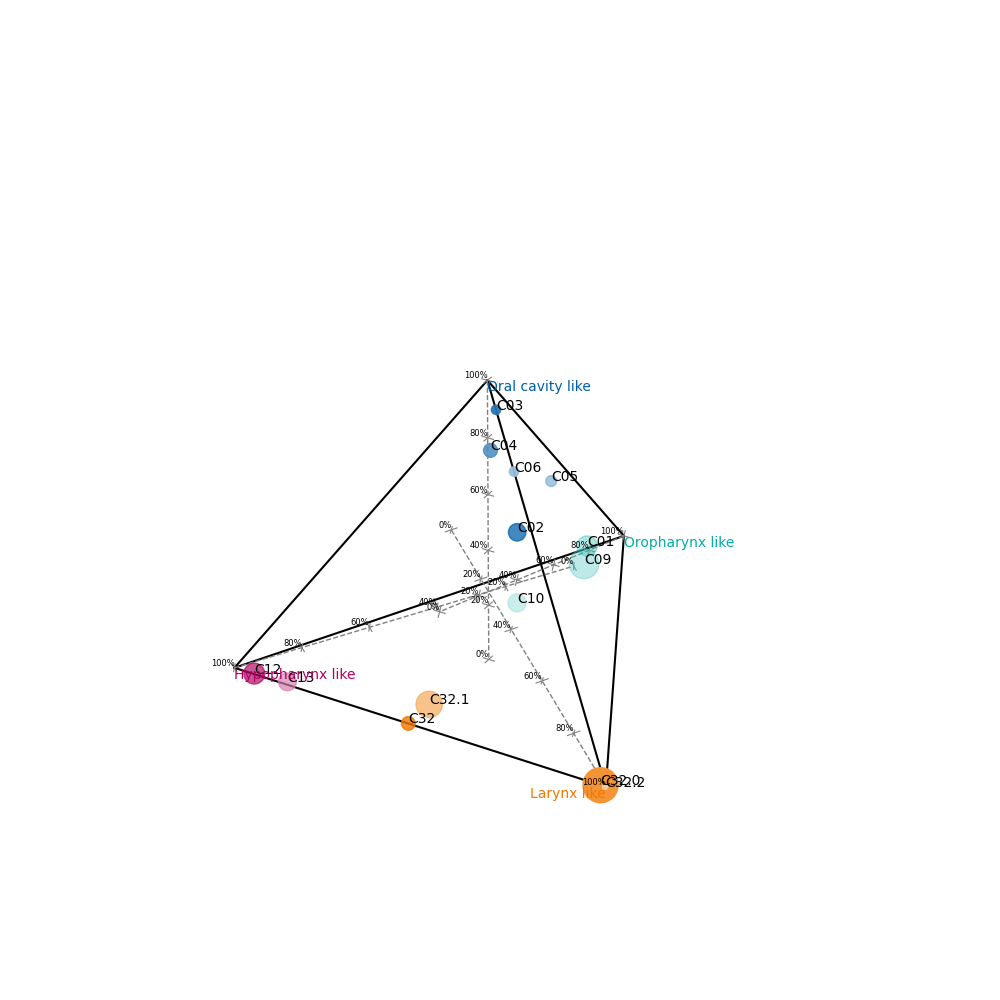

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

%matplotlib widget

subsites = ['C02', 'C03', 'C04', 'C05', 'C06', 'C01', 'C09', 'C10', 'C12', 'C13','C32', 'C32.0', 'C32.1', 'C32.2']
simplex_matrix = np.zeros((len(subsites), 3))
for index, subsite in enumerate(subsites):
    simplex_matrix[index] = p_to_xyz(matrix[subsite])
odered_value_counts = dataset_staging_main_groups['tumor']['1']['subsite'].value_counts()[subsites]
sizes = odered_value_counts * 3

# Sizes for each point
ordered_value_counts = dataset_staging_main_groups['tumor']['1']['subsite'].value_counts()[subsites]
sizes = np.array(ordered_value_counts) * 1  # Adjust the scaling if necessary

# Create a 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Extract coordinates from simplex_matrix
x_coords = simplex_matrix[:, 0]
y_coords = simplex_matrix[:, 1]
z_coords = simplex_matrix[:, 2]

# Scatter plot with specific colors and sizes
scatter = ax.scatter(x_coords, y_coords, z_coords, c=colors_ordered, s=sizes, marker='o')

# Add text labels for each subsite
for i, subsite in enumerate(subsites):
    ax.text(x_coords[i], y_coords[i], z_coords[i], subsite)
    x_extremes = [-1,1,0,0]
    y_extremes = [-0.5773502691896258,-0.5773502691896258,1.1547005383792517,0]
    z_extremes = [-0.5773502691896258,-0.5773502691896258,-0.5773502691896258,1.2247448713915892]
plotter_x = x_extremes.copy()
plotter_x.append(x_extremes[0])
plotter_x.append(x_extremes[2])
plotter_y = y_extremes.copy()
plotter_y.append(y_extremes[0])
plotter_y.append(y_extremes[2])
plotter_z = z_extremes.copy()
plotter_z.append(z_extremes[0])
plotter_z.append(z_extremes[2])

ax.plot(plotter_x, plotter_y,plotter_z, c='k')
ax.plot([x_extremes[1],x_extremes[3]], [y_extremes[1],y_extremes[3]],[z_extremes[1],z_extremes[3]], c='k')
extremes = np.array((x_extremes,y_extremes,z_extremes)).T
center0 = (extremes[1]+extremes[2]+extremes[3])/3
center1 = (extremes[0]+extremes[2]+extremes[3])/3
center2 = (extremes[0]+extremes[1]+extremes[3])/3
center3 = (extremes[0]+extremes[1]+extremes[2])/3

component_larynx = mixture.get_mixture_coefs()['C32.0'].argmax()
component_oropharynx = mixture.get_mixture_coefs()['C01'].argmax()
component_oral_cavity = mixture.get_mixture_coefs()['C03'].argmax()
component_hypopharynx = mixture.get_mixture_coefs()['C13'].argmax()

ax.text(extremes[component_larynx,0], extremes[component_larynx,1], extremes[component_larynx,2], "Larynx like", fontsize=10, ha='right', va='top',c = usz_orange)
ax.text(extremes[component_oropharynx,0], extremes[component_oropharynx,1], extremes[component_oropharynx,2], "Oropharynx like", fontsize=10, ha='left', va='top',c = usz_green)
ax.text(extremes[component_oral_cavity,0], extremes[component_oral_cavity,1], extremes[component_oral_cavity,2], "Oral cavity like", fontsize=10, ha='left', va='top',c = usz_blue)
ax.text(extremes[component_hypopharynx,0], extremes[component_hypopharynx,1], extremes[component_hypopharynx,2], "Hypopharynx like", fontsize=10, ha='left', va='top',c = usz_red)



add_perpendicular_crosses_3d(ax, extremes[0, 0], extremes[0, 1], extremes[0, 2], center0[0], center0[1], center0[2])
plt.plot([extremes[0,0], center0[0]], [extremes[0,1], center0[1]],[extremes[0,2],center0[2]], color='gray', linestyle='--', linewidth=1)
add_perpendicular_crosses_3d(ax, extremes[1, 0], extremes[1, 1], extremes[1, 2], center1[0], center1[1], center1[2])
plt.plot([extremes[1,0], center1[0]], [extremes[1,1], center1[1]],[extremes[1,2],center1[2]], color='gray', linestyle='--', linewidth=1)
add_perpendicular_crosses_3d(ax, extremes[2, 0], extremes[2, 1], extremes[2, 2], center2[0], center2[1], center2[2])
plt.plot([extremes[2,0], center2[0]], [extremes[2,1], center2[1]],[extremes[2,2],center2[2]], color='gray', linestyle='--', linewidth=1)
add_perpendicular_crosses_3d(ax, extremes[3, 0], extremes[3, 1], extremes[3, 2], center3[0], center3[1], center3[2])
plt.plot([extremes[3,0], center3[0]], [extremes[3,1], center3[1]],[extremes[3,2],center3[2]], color='gray', linestyle='--', linewidth=1)

legend_text = []
for index in range(len(subsites)):
    legend_text.append(subsites[index] + ', ' + str(odered_value_counts[index]) + ' patients')

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=text)
                   for color, text in zip(colors_ordered, legend_text)]

# Add a legend with fixed dot sizes
# plt.legend(handles=legend_elements, loc='upper right', title='Subsites', fontsize='small')

plt.gca().set_axis_off()
plt.show()
